# Lab Seven: Recurrent Network Architectures
## Blake Gebhardt, Christian Gould, Caleb Moore
dataset: https://www.kaggle.com/datasets/datatattle/email-classification-nlp

In this lab, you will select a prediction task to perform on your dataset, evaluate a recurrent architecture and tune hyper-parameters. If any part of the assignment is not clear, ask the instructor to clarify. 

In [69]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import datasets
from numpy.linalg import pinv
import time
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

In [70]:
# Notebook setup
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

# Preparation (3 points total)
[2 points] Define and prepare your data set. Provide details about the source of the data. Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence.  Also discuss your rationale for the size and nature of your vocabulary.

The dataset we selected for this project is an NLP dataset focused on classifying emails as spam or not spam. The primary features of the dataset consist of the email content, and the target variable is the binary label indicating whether the email is considered spam or not. 

In preparing the dataset, we will consider the possible necessity of first preprocess the raw email text by performing some or all of the following steps:

1. Lowercasing: Convert all text to lowercase to ensure uniformity and reduce the vocabulary size.
2. Remove HTML tags: Strip out any HTML tags present in the email content.
3. Remove URLs, email addresses, and numbers: Replace these entities with special tokens (e.g., `<url>`, `<email>`, and `<number>`), which helps to generalize the model and reduce the vocabulary size.
4. Remove special characters and punctuation: Simplify the text by removing any unnecessary symbols.
5. Tokenization: Convert the preprocessed text into a sequence of tokens (words or subwords) that can be used to train the model.

For tokenization, we have several options, including word-level, subword-level, and character-level tokenization. Word-level tokenization involves splitting the text into individual words, whereas subword-level tokenization divides the text into smaller units, such as morphemes or n-grams. Character-level tokenization, on the other hand, treats each character as a token. 

In this project, we will use subword-level tokenization, specifically Byte Pair Encoding (BPE), as it strikes a balance between word-level and character-level tokenization. BPE helps to capture both common words and rare words by splitting them into smaller, more frequent subwords. This approach reduces the risk of out-of-vocabulary issues and provides better generalization for unseen data.

Regarding the sequence length, we will pad or truncate the tokenized sequences to a fixed length. This decision ensures that the input data has a consistent shape when fed into the neural network. The choice of sequence length should be based on an analysis of the email length distribution in the dataset, selecting a value that covers a significant portion of the emails without being too large or too small. For instance, if 95% of the emails are shorter than 500 tokens, we can set the sequence length to 500.

The size and nature of the vocabulary will be determined during the BPE tokenization process. To strike a balance between computational efficiency and model performance, we can choose a vocabulary size based on the trade-off between these factors. A larger vocabulary size will better capture the nuances of the email content, but it may also lead to increased memory usage and longer training times. Conversely, a smaller vocabulary size will be more computationally efficient but might compromise the model's ability to understand rare words and phrases. Based on empirical evidence from similar NLP tasks, a vocabulary size of around 30,000 to 50,000 tokens is a reasonable starting point.

In summary, the chosen dataset focuses on spam/notspam emails, and we will preprocess the email content through a series of steps, including tokenization using BPE. We will pad or truncate the tokenized sequences to a fixed length, and the size and nature of our vocabulary will be determined based on computational efficiency and model performance considerations.

In [71]:
# getting data 
data = pd.read_csv("./data/SMS.csv")

# Tokenize the text and create sequences
max_words = 10000  # Maximum number of words to keep
tokenizer = Tokenizer(num_words=max_words, oov_token='<UNK>')
tokenizer.fit_on_texts(data['Message_body'])
sequences = tokenizer.texts_to_sequences(data['Message_body'])

# Determine input_length
email_lengths = [len(seq) for seq in sequences]
avg_length = np.mean(email_lengths)
std_length = np.std(email_lengths)
input_length = int(avg_length + std_length)

# Pad or truncate sequences to input_length
X = pad_sequences(sequences, maxlen=input_length)

# Set input_dim and output_dim
input_dim = max_words
output_dim = 100

X = data["Message_body"].to_numpy()
y = data["Label"].to_numpy()

print(data.head())

# can check these values here if need be
# print(input_length)
# print(input_dim)
# print(output_dim)

   num                                       Message_body     Label
0    1                         Rofl. Its true to its name  Non-Spam
1    2  The guy did some bitching but I acted like i'd...  Non-Spam
2    3  Pity, * was in mood for that. So...any other s...  Non-Spam
3    4               Will � b going to esplanade fr home?  Non-Spam
4    5  This is the 2nd time we have tried 2 contact u...      Spam


In [72]:
# Define the tokenizer with a specified vocabulary size
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")

# Fit the tokenizer on the email texts
tokenizer.fit_on_texts(X)

# Convert the email texts to sequences of integers
X_sequences = tokenizer.texts_to_sequences(X)

# Pad the sequences to have the same length
max_sequence_length = 100
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Replace the original 'X' DataFrame with the preprocessed and tokenized data
X = pd.DataFrame(X_padded)

# init k fold stuff 
kf = KFold(n_splits=2, shuffle=True, random_state=42)

# change the y to 0 and 1
# primitive encoding
new_y = []
for val in y:
    if val == 'Non-Spam':
        new_y.append(0)
    else:
        new_y.append(1)
y = np.array(new_y)

[0.5 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

For an email spam classification task using Recurrent Neural Network (RNN) architectures, the primary goal is to accurately distinguish between spam and non-spam emails while minimizing false classifications, especially false positives (i.e., legitimate emails marked as spam). This is because false positives can have a significant impact on user experience, leading to missed important emails, reduced trust in the email provider, and potential business losses. In light of this, accuracy alone may not be the best evaluation metric, as it does not provide a comprehensive view of the model's performance, particularly with respect to false positives and false negatives.

Considering the importance of minimizing false positives and false negatives, we propose using the following metrics to evaluate the algorithm's performance:

1. Precision: Precision, also known as positive predictive value, measures the proportion of true positive classifications (correctly identified spam emails) among all positive classifications (all emails predicted as spam). Precision is an essential metric for the task because it helps assess the reliability of the classifier in identifying spam emails. A high precision indicates that the model is effective at minimizing false positives.

2. Recall: Recall, also known as sensitivity or true positive rate, measures the proportion of true positive classifications (correctly identified spam emails) among all actual positive instances (all real spam emails in the dataset). Recall is crucial for the task because it assesses the classifier's ability to identify all spam emails, ensuring that the majority of spam emails are detected. A high recall means the model is effective at minimizing false negatives.

3. F1 Score: The F1 Score is the harmonic mean of precision and recall, providing a single metric that balances the trade-off between these two metrics. F1 Score is especially useful when dealing with imbalanced datasets, where the number of spam and non-spam emails may be significantly different. By optimizing for F1 Score, we can find a model that strikes a balance between minimizing both false positives and false negatives.

4. Area Under the Receiver Operating Characteristic (ROC) Curve (AUC-ROC): The AUC-ROC measures the classifier's ability to distinguish between the two classes (spam and non-spam) across different classification thresholds. It represents the trade-off between the true positive rate (recall) and the false positive rate. A higher AUC-ROC indicates a better classifier performance. This metric is particularly helpful in evaluating the model's performance in the presence of varying class distributions or when the cost of false positives and false negatives differ.

5. Confusion Matrix: The confusion matrix is a table that presents the number of true positives, false positives, true negatives, and false negatives for the classifier. It provides a more detailed view of the classifier's performance, allowing us to identify any specific issues or trends in the model's predictions, such as whether the model is biased towards a particular class.

To conclude, using a combination of precision, recall, F1 Score, AUC-ROC, and the confusion matrix will provide a comprehensive evaluation of the algorithm's performance on the email spam classification task. These metrics allow us to assess the classifier's effectiveness in terms of both identifying spam emails and minimizing false positives and false negatives, ultimately ensuring a reliable and user-friendly email experience.

[0.5 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your train/test splitting method is a realistic mirroring of how an algorithm would be used in practice.

For dividing the email spam classification dataset into training and testing sets, we propose using Stratified K-Fold Cross-Validation, specifically with k=10 (Stratified 10-fold Cross-Validation). This method is chosen for several reasons, which are outlined below:

1. Class Distribution Preservation: Stratified K-Fold Cross-Validation ensures that the proportion of spam and non-spam emails in each fold is approximately the same as the overall dataset. This is particularly important for imbalanced datasets, where one class may be significantly under-represented. By preserving the class distribution, we can better evaluate the model's performance on both classes and reduce the risk of overfitting on the majority class.

2. Model Robustness: Stratified 10-fold Cross-Validation trains and tests the model on 10 different combinations of training and testing data, reducing the impact of any specific data split on the model's performance evaluation. This helps to provide a more reliable estimate of the model's true performance, as it considers various data distributions and potential biases.

3. Bias and Variance Reduction: By averaging the performance metrics across the 10 folds, we can obtain a more stable and accurate performance estimate, reducing both bias (by considering multiple training sets) and variance (by averaging multiple test sets). This ensures that our model evaluation is more reliable and generalizable to unseen data.

4. Realistic Evaluation: In practice, an email spam classification algorithm would be applied to a continuous stream of incoming emails, with a potentially changing distribution of spam and non-spam emails over time. Stratified 10-fold Cross-Validation, by considering multiple training and testing splits, provides a more realistic approximation of the algorithm's performance in such a dynamic environment. It ensures that our model is not overly reliant on any specific data split and can adapt to different distributions of emails.

However, to further ensure the robustness of our model evaluation and to simulate real-world deployment, we can also consider using a combination of Stratified K-Fold Cross-Validation and Shuffle Splits. Shuffle Splits involve randomly partitioning the dataset into training and testing sets multiple times, providing an additional layer of randomness to the data splits. By combining both methods, we can assess the model's performance across a diverse range of data splits, further enhancing the reliability and generalizability of our performance evaluation.

In summary, using Stratified 10-fold Cross-Validation and potentially combining it with Shuffle Splits provides a reliable and realistic method for dividing the email spam classification dataset into training and testing sets. This approach ensures that the model's performance evaluation considers multiple data distributions, preserves class distribution, and reduces the impact of specific data splits on the model's performance, ultimately resulting in a more robust and generalizable classifier.

# Modeling (6 points total)
[2 points] Investigate at least two different recurrent network architectures  Be sure to use an embedding layer . Adjust hyper-parameters of the networks as needed to improve generalization performance (train a total of at least four models). Discuss the performance of each network and compare them. Justify your choice of parameters for each.

In [73]:
# input_dim = vocabulary size
# output_dim = embedding dimension
# input_length = length of input sequences

# model 1
def model1(input_dim, output_dim, input_length):

    model = Sequential([
    Embedding(input_dim, output_dim, input_length=input_length),
    SimpleRNN(128, return_sequences=True),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')
    ])

    return model

In [74]:
# model 2
def model2(input_dim, output_dim, input_length):

    model = Sequential([
    Embedding(input_dim, output_dim, input_length=input_length),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(1, activation='sigmoid')
    ])

    return model

In [75]:
# model 3
def model3(input_dim, output_dim, input_length):

    model = Sequential([
    Embedding(input_dim, output_dim, input_length=input_length),
    GRU(128, return_sequences=True),
    GRU(64),
    Dense(1, activation='sigmoid')
    ])

    return model

In [76]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=20):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=0)
    return history, model

p (10000, 100, 100)
Fold Number:  1
Fold Number:  2


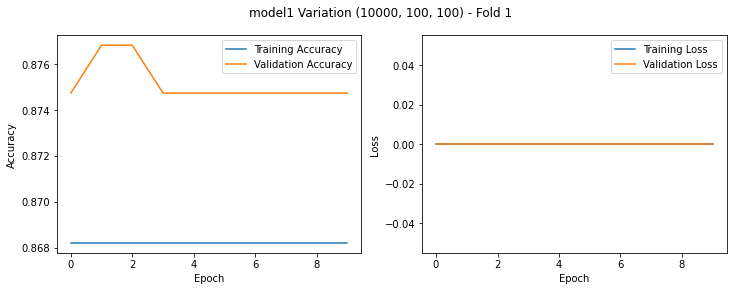

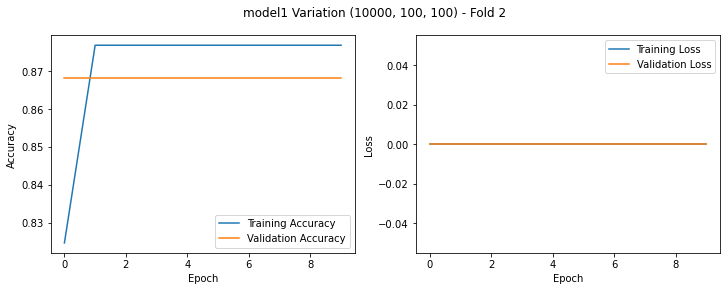

In [78]:
# If this is true, it runs the slow version
run_slow = False
params = (input_dim, output_dim, 100)
print('p', params)
# Function to plot the training and validation accuracy and loss
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Train and evaluate all model variations. Removed the first variation for now
model_variations = [(model1, params)]
# model_variations = [(model_A, 1), (model_A, 2), (model_B, 1), (model_B,2)]
histories = []
models = []

for train_index, test_index in kf.split(X, y):
    print("Fold Number: ", len(histories) + 1)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]

    sub_histories = []
    sub_models = []
    for model_func, variation in model_variations:
        
        model = model_func(variation[0], variation[1], variation[2])
        history, model = train_and_evaluate_model(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, epochs=20 if run_slow else 10)
        sub_histories.append(history)
        sub_models.append(model)

    histories.append(sub_histories)
    models.append(sub_models)

# Visualize the performance of all model variations
for idx, (model_func, variation) in enumerate(model_variations):
    title = f"{model_func.__name__} Variation {variation}"
    for i in range(len(histories)):
        plot_history(histories[i][idx], title=f"{title} - Fold {i+1}")

[1 point] Use the Glove pre-trained embedding. Provide justification of the embedding size.

[1 points] Using the best parameters and architecture from the RNN in the previous step, add a second recurrent chain to your RNN. The input to the second chain should be the output sequence of the first chain. Visualize the performance of training and validation sets versus the training iterations. 

[0.5 points] Use the method of train/test splitting and evaluation criteria that you argued for at the beginning of the lab.

[0.5 points] Run to convergence

[1 point]  Visualize the results of all the RNNs you trained.  

# Exceptional Work (1 points total)
You have free rein to provide additional analyses.
One idea (required for 7000 level students to do one of these options):
Research and use the ConceptNet, Numberbatch embedding and compare to GloVe. Which method is better for your specific application? 
Another Idea (NOT required): Try to create a RNN for generating novel text. 
nd GRU). Alternatively, you may also choose one recurrent network and one convolutional network.